# Exercise: Feature selection - system state prediction

In this exercise, we will use logistic regression as a classifier to predict system imbalance state using features such as past imbalance volumes, past imbalance prices, day-ahead prices, renewable dispatch, and others. Predicting imbalance state has applications in short-term trading, where the arbitrage between day-ahead/intraday and imbalance price is strongly correlated with the system imbalance state. We construct three classes; short, long, neutral, signifying the state of system imbalance. Short and long refers to system state in case of deficit and excess of generation, respectively, and neutral refers to low imbalance. We introduce the class *neutral* since it is hard to predict the imbalance state in case of low imbalance. Logistic regression models the log-probability of an event as a linear combination of features, using the logistic function reading as
$$
p(x; w,b) = \frac{1}{1+e^{w^\top x + b}},
$$
where $w$ and $b$ are weights and bias corresponding to the linear combination, and we define p to represent the probability of the system being long. Note that the logistic function returns values between 0 and 1.

To build a classifier from logistic regressor, we define a *threshold* parameter $\theta$, such that an instance is classified as long if $p/(1-p)>\theta$, and short if $p/(1-p)<1/\theta$, else neutral.

## 1 - Time series prediction using past imbalance volumes
In this section, we will use only the past imbalance volumes as features to predict the next imbalance state. For instance, to predict the imbalance state at time t, we can use the last n imbalance volumes for slots t-n, ..., t-1 as features and fit a logistic regressor.

Now, we describe the metrics used to evaluate our classifier's performance. First, we have *accuracy* which denotes the number of samples classified correctly as either long of short, excluding those classified as neutral.

Next, we have the proportion of dropped instances, meaning the proportion of instances classified as neutral.

Next, we have the logloss (cross entropy) evaluated on validation set which is the same objective used for training the logistic regressor.

$$
- \sum_i y_i \log(p(x_i; w,b)) + (1-y_i)\log(1-p(x_i;w,b))
$$
### Tasks

- First, let us prepare the data from the given dataset. The dataset provides us with volumes for T slots. Prepare features and targets for a look back window of size n?
- Split the dataset into training and validation sets.
- Train a linear regressor and evaluate it on the validation set using accuracy and proportion of dropped instances.
- Plot performance as a function of window size and find a good window size.

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.metrics import zero_one_loss, log_loss
import pandas as pd
import numpy as np

def get_data(N, dataset):
    # -------------------------------------------------------------------------
    # Load the dataset and preprocess it to create a supervised learning problem.
    df = pd.read_csv(dataset)
    T = len(df)
    data_dict = {f"Imbalance t-{N+1-n}": df["Imbalance"].values[n-1:T-N+n-1] for n in range(1, N+1)}
    data_dict["Direction"] = df["Direction"].values[N:T]
    data_dict["Slot Id"] = df["Slot Id"].values[N:T]
    data = pd.DataFrame(columns=['Slot Id'] + [f"Imbalance t-{N+1-n}" for n in range(1, N+1)] + ["Direction"], data=data_dict)
    return data

def train_log_regressor(data: pd.DataFrame, drop = [], reg = 1):
    """
    Trains a logistic regressor to predict 'Imbalance price' using all the other features in the dataset, dropping the features in the 'drop' list.
    """
    # -------------------------------------------------------------------------
    # Split the dataset into training and validation sets. Scikit-learn offers a train_test_split function, check documentation.
    train_df, val_df = train_test_split(data.drop(columns=drop), test_size=0.2, random_state=42, shuffle=False)

    # -------------------------------------------------------------------------
    # TODO:Train a linear regression model on the training set and evaluate it on the test set. You may LogisticRegression from sklearn.linear_model. https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
    model = LogisticRegression(C=1/reg, max_iter=1000)
    model.fit(train_df.drop(columns=["Slot Id", "Direction"]),
            train_df["Direction"])
    return model, val_df
    
    # return model, val_df

def evaluate(df, model, threshold = 2):
    # -------------------------------------------------------------------------
    # Evaluate the model
    prob_preds = model.predict_proba(df.drop(columns=["Slot Id", "Direction"]))
    logloss = log_loss(df["Direction"], prob_preds)

    conf_surplus = prob_preds[:, 1]/prob_preds[:, 0]
    preds = np.where(conf_surplus>=threshold, 1, 0)
    preds = np.where(conf_surplus<1/threshold, -1, preds)
    
    neutral = 0
    true = 0
    false = 0
    for i in range(len(df["Direction"])):
        if preds[i] == 0:
            neutral += 1
        elif preds[i] == df["Direction"].iloc[i]:
            true += 1
        else:
            false += 1
    
    accuracy = true/(true+false)
    dropped_instances = neutral/(true+false+neutral)

    return {'logloss': logloss, 'accuracy': accuracy, 'dropped_instances': dropped_instances, 'coef': model.coef_, 'intercept': model.intercept_}

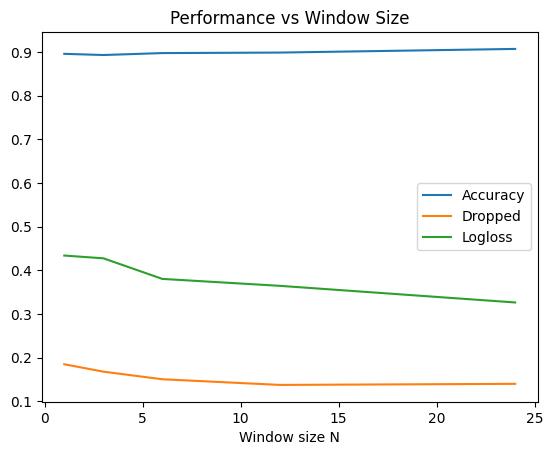

In [3]:
import numpy as np
dataset = "imbalance_features_2025_06_train.csv"

# TODO:Analyze the effect of the window size N on the model performance by using the functions above and plotting performance metrics as a function of N.
results = []

for N in [1, 3, 6, 12, 24]:
    data = get_data(N, dataset)
    model, val_df = train_log_regressor(data)
    metrics = evaluate(val_df, model, threshold=2)
    results.append({'N': N, **metrics})

# Convert to DataFrame and plot
results_df = pd.DataFrame(results)

plt.figure()
plt.plot(results_df["N"], results_df["accuracy"], label="Accuracy")
plt.plot(results_df["N"], results_df["dropped_instances"], label="Dropped")
plt.plot(results_df["N"], results_df["logloss"], label="Logloss")
plt.xlabel("Window size N")
plt.legend()
plt.title("Performance vs Window Size")
plt.show()


The logistic regression classifier performs consistently well (≈90% accuracy) across all tested window sizes.
As the look-back window increases, the model becomes slightly more confident (fewer neutral classifications) and better calibrated (lower logloss).
However, the gain is small beyond ~10 past imbalance steps, indicating limited benefit from longer historical context.

# 2 - Time series prediction with external features
Since, the imbalance volume is affected by other market quantities, we include external features to improve our model. Note that, only features that are available a-priori to the delivery time are valid features, since prediction model needs to be run before delivery time.

### Tasks
- Now, use other features in the dataset as well. Try to find a nice set of features that are useful or use regularization for feature selection.
- How does the performance vary with the threshold parameter $\theta$?

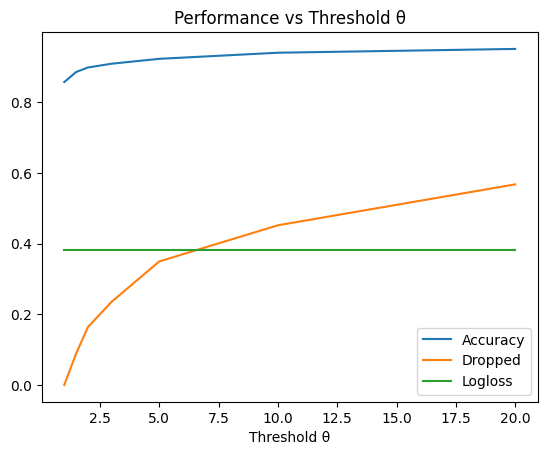

In [8]:
def get_data_ex_features(N, dataset):
    df = pd.read_csv(dataset)
    data = get_data(N, dataset)
    data = data.merge(df.drop(columns=["Time slot", "Direction", "Imbalance", "Imbalance price"]), on="Slot Id") # Only a-priori available quantities can be used as features
    return data

dataset = "imbalance_features_2025_06_train.csv"
#TODO: Analyze the effect of threshold on the model performance

results = []
N = 6  # good window size found before
data = get_data_ex_features(N, dataset)

model, val_df = train_log_regressor(data, reg=1)

for theta in [1.0, 1.5, 2.0, 3.0, 5.0,10.0, 20.0]:
    metrics = evaluate(val_df, model, threshold=theta)
    results.append({'theta': theta, **metrics})

results_df = pd.DataFrame(results)

plt.figure()
plt.plot(results_df["theta"], results_df["accuracy"], label="Accuracy")
plt.plot(results_df["theta"], results_df["dropped_instances"], label="Dropped")
plt.plot(results_df["theta"], results_df["logloss"], label="Logloss")
plt.xlabel("Threshold θ")
plt.title("Performance vs Threshold θ")
plt.legend()
plt.show()

Increasing θ makes the classifier more cautious.
It only labels cases as long or short when it’s confident, so accuracy improves but coverage drops.
Logloss stays constant because the underlying probabilities don’t change — only how you interpret them does.

## 3 - Time series prediction with polynomial features
Recall how polynomial regression was implemented by using polynomial features in linear regression in the ridge and lasso exercise and your assignment. Here, we want to do the same for our problem, by using polynomial features in logistic regression.

### Tasks
- How is the performance with polynomial features?
- See if regularization helps, how can you increase regularization?
- How does the performance vary with the threshold parameter $\theta$?

In [14]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

def train_poly(data, drop = [], reg = 1):

    # Prepare data
    X = data.drop(columns=["Slot Id", "Direction"] + drop)
    y = data["Direction"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    # Polynomial feature transformation
    poly = PolynomialFeatures(degree=2, include_bias=False)
    scaler = StandardScaler()

    # Fit scaler on training data only
    X_train_poly = poly.fit_transform(X_train)
    X_train_poly = scaler.fit_transform(X_train_poly)

    X_test_poly = poly.transform(X_test)
    X_test_poly = scaler.transform(X_test_poly)

    # Logistic regression with regularization
    model = LogisticRegression(C=1/reg, penalty='l2', solver='lbfgs', max_iter=1000)
    model.fit(X_train_poly, y_train)

    return model, y_test.reset_index(drop=True), X_test_poly

def evaluate_poly(features, targets, model, threshold=2):
    # -------------------------------------------------------------------------
    # Evaluate the model
    prob_preds = model.predict_proba(features)
    logloss = log_loss(targets, prob_preds)

    conf_surplus = prob_preds[:, 1]/prob_preds[:, 0]
    preds = np.where(conf_surplus>=threshold, 1, 0)
    preds = np.where(conf_surplus<1/threshold, -1, preds)
    
    neutral = 0
    true = 0
    false = 0
    for i in range(len(targets)):
        if preds[i] == 0:
            neutral += 1
        elif preds[i] == targets[i]:
            true += 1
        else:
            false += 1
    
    accuracy = true/(true+false)
    dropped_instances = neutral/(true+false+neutral)

    return {'logloss': logloss, 'accuracy': accuracy, 'dropped_instances': dropped_instances, 'coef': model.coef_, 'intercept': model.intercept_}
    

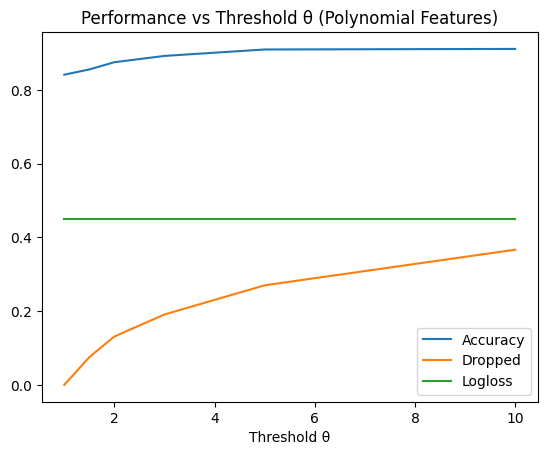

In [16]:
# TODO: Analyze the effect of the threshold on the model performance#
data = get_data_ex_features(6, dataset)
model, y_test, X_test_poly = train_poly(data, reg=1)

results = []
for theta in [1.0, 1.5, 2.0, 3.0, 5.0, 10.0]:
    metrics = evaluate_poly(X_test_poly, y_test, model, threshold=theta)
    results.append({'theta': theta, **metrics})

results_df = pd.DataFrame(results)

plt.figure()
plt.plot(results_df["theta"], results_df["accuracy"], label="Accuracy")
plt.plot(results_df["theta"], results_df["dropped_instances"], label="Dropped")
plt.plot(results_df["theta"], results_df["logloss"], label="Logloss")
plt.xlabel("Threshold θ")
plt.title("Performance vs Threshold θ (Polynomial Features)")
plt.legend()
plt.show()

In [18]:
# ============================================================
# FINAL MODEL EVALUATION ON TEST SET
# ============================================================

from sklearn.preprocessing import PolynomialFeatures, StandardScaler

# 1. Load test dataset
dataset_test = "imbalance_features_2025_06_test.csv"
data_test = get_data_ex_features(6, dataset_test)  # use same window size as training

# 2. Separate features and target
X_test = data_test.drop(columns=["Slot Id", "Direction"])
y_test = data_test["Direction"].reset_index(drop=True)

# 3. Recreate polynomial and scaling transformations (same as training setup)
#    You must use the same transformations used when training your model.
#    Fit them on the *training* data to replicate scaling correctly.
X_train = data_train.drop(columns=["Slot Id", "Direction"])

poly = PolynomialFeatures(degree=2, include_bias=False)
scaler = StandardScaler()

poly.fit(X_train)
X_train_poly = poly.transform(X_train)
scaler.fit(X_train_poly)

# 4. Transform the test data
X_test_poly = poly.transform(X_test)
X_test_poly = scaler.transform(X_test_poly)

# 5. Evaluate on test data using given evaluation function
metrics_test = evaluate_poly(X_test_poly, y_test, final_model, threshold=2)

# 6. Print results
print("==============================================")
print("FINAL MODEL PERFORMANCE ON TEST SET")
print("==============================================")
print(f"Accuracy:           {metrics_test['accuracy']:.3f}")
print(f"Dropped instances:  {metrics_test['dropped_instances']:.3f}")
print(f"Logloss:            {metrics_test['logloss']:.3f}")
print("==============================================")

FINAL MODEL PERFORMANCE ON TEST SET
Accuracy:           0.894
Dropped instances:  0.230
Logloss:            0.405


COMPARISON OF DIFFERENT LOGISTIC REGRESSION APPROACHES
                     Model  Accuracy  Dropped  Logloss
   1 - Past imbalance only     0.912    0.294    0.368
2 - With external features     0.915    0.273    0.369
   3 - Polynomial features     0.906    0.279    0.411


/Users/jonaswiendl/local/Repos/46765_ML4ES/ml4es_exercises/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


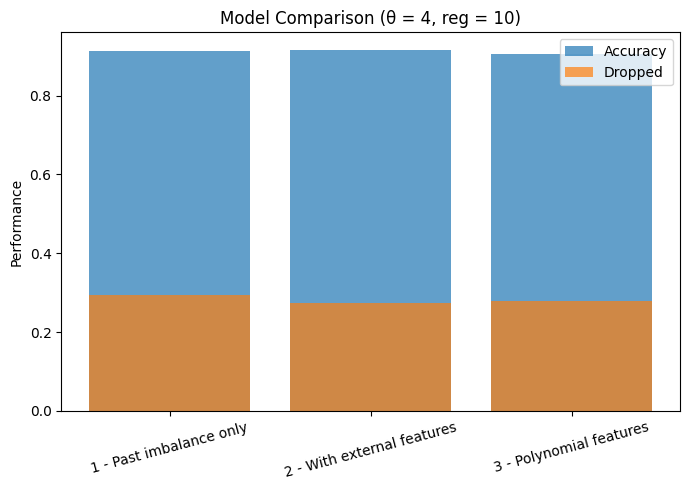

In [22]:
# ============================================================
# COMPARISON OF DIFFERENT LOGISTIC REGRESSION APPROACHES
# ============================================================

import pandas as pd
import matplotlib.pyplot as plt

# Common setup
dataset_train = "imbalance_features_2025_06_train.csv"
N = 10
theta = 4
reg = 10

# ------------------------------------------------------------
# MODEL 1: Past imbalance volumes only
# ------------------------------------------------------------
data1 = get_data(N, dataset_train)
model1, val_df1 = train_log_regressor(data1, reg=reg)
metrics1 = evaluate(val_df1, model1, threshold=theta)

# ------------------------------------------------------------
# MODEL 2: Add external (a-priori) features
# ------------------------------------------------------------
data2 = get_data_ex_features(N, dataset_train)
model2, val_df2 = train_log_regressor(data2, reg=reg)
metrics2 = evaluate(val_df2, model2, threshold=theta)

# ------------------------------------------------------------
# MODEL 3: Polynomial features (nonlinear logistic regression)
# ------------------------------------------------------------
model3, y_val3, X_val3_poly = train_poly(data2, reg=reg)
metrics3 = evaluate_poly(X_val3_poly, y_val3.reset_index(drop=True), model3, threshold=theta)

# ------------------------------------------------------------
# Collect all results
# ------------------------------------------------------------
results_compare = pd.DataFrame([
    {"Model": "1 - Past imbalance only", "Accuracy": metrics1["accuracy"],
     "Dropped": metrics1["dropped_instances"], "Logloss": metrics1["logloss"]},
    {"Model": "2 - With external features", "Accuracy": metrics2["accuracy"],
     "Dropped": metrics2["dropped_instances"], "Logloss": metrics2["logloss"]},
    {"Model": "3 - Polynomial features", "Accuracy": metrics3["accuracy"],
     "Dropped": metrics3["dropped_instances"], "Logloss": metrics3["logloss"]},
])

# ------------------------------------------------------------
# Print comparison table
# ------------------------------------------------------------
print("==============================================")
print("COMPARISON OF DIFFERENT LOGISTIC REGRESSION APPROACHES")
print("==============================================")
print(results_compare.to_string(index=False, float_format="%.3f"))

# ------------------------------------------------------------
# Visualize the results
# ------------------------------------------------------------
plt.figure(figsize=(7,5))
plt.bar(results_compare["Model"], results_compare["Accuracy"], label="Accuracy", alpha=0.7)
plt.bar(results_compare["Model"], results_compare["Dropped"], label="Dropped", alpha=0.7)
plt.ylabel("Performance")
plt.title(f"Model Comparison (θ = {theta}, reg = {reg})")
plt.legend()
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()